In [1]:
#!pip install gensim
import json
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras import regularizers
import tensorflow as tf
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
from sklearn.metrics import classification_report
from gensim.models import FastText


2024-03-11 14:05:11.306775: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-11 14:05:11.353280: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-11 14:05:11.353313: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-11 14:05:11.354567: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-11 14:05:11.362168: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import tensorflow as tf

# Check available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the second GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

2 Physical GPU, 1 Logical GPU


2024-03-11 14:05:15.721673: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14408 MB memory:  -> device: 1, name: NVIDIA RTX A4000, pci bus id: 0000:af:00.0, compute capability: 8.6


In [3]:
# use word2vec
def load_data(file):
    with open(file, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data

data = load_data("Dataset1-NamedEntityRecognition_train.json")

texts = [data[key]["text"] for key in data]
words = [sentence.split() for sentence in texts]
nested_labels = [data[key]["labels"] for key in data]


In [4]:
def load_data(file):
    with open(file, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data

data = load_data("Dataset1-NamedEntityRecognition_train.json")

texts = [data[key]["text"] for key in data]

# Compute the maximum length of the texts
max_length = max(len(text.split()) for text in texts)

print("Maximum length of text:", max_length)


Maximum length of text: 70


In [5]:
# Create FastText model
fasttext_model = FastText(sentences=words, vector_size=100, min_count=1, epochs=10)

# Create word vectors dictionary with consistent lowercase keys
word_vectors = {}
for word in fasttext_model.wv.index_to_key:
    try:
        word_vectors[word.lower()] = fasttext_model.wv[word.lower()]
    except KeyError:
        # Handle out-of-vocabulary words
        pass

# Handle out-of-vocabulary (OOV) words in get_word_vector function
def get_word_vector(word):
    word_lower = word.lower()  # Ensure lowercase for consistency
    if word_lower in word_vectors:
        return word_vectors[word_lower]
    else:
        # Choose an appropriate strategy for OOV words:
        # - Return the zero vector (default)
        # - Use word averaging or other embedding techniques
        # - Handle OOV cases differently depending on your specific requirements
        return np.zeros(fasttext_model.vector_size)
    
# Embed sentences
word_embeddings = [[get_word_vector(word) for word in sentence] for sentence in words]


In [6]:
for sentence in word_embeddings:
    sentence_length = len(sentence)
    if sentence_length < 70: #max length of sentence = 70
        while len(sentence) < 70:
            sentence.append(np.zeros(100))     

# padding to convert into (9435, 70, 100)  from (9435, variable_length, 70)           
for i in range(len(word_embeddings)):
    word_embeddings[i] = np.array(word_embeddings[i])
word_embeddings = np.array(word_embeddings)
word_embeddings.shape            

(9435, 70, 100)

In [7]:
flat_labels = [label for sublist in nested_labels for label in sublist]

# Find unique labels
unique_labels = set(flat_labels)

print(unique_labels)

label2idx = {label: idx for idx, label in enumerate(unique_labels)}
labels_idx = [[label2idx[label] for label in sublist] for sublist in nested_labels]

# One-hot encode labels
num_classes = len(unique_labels)
one_hot_labels = [to_categorical(sublist, num_classes=num_classes) for sublist in labels_idx]
def convert_to_list(lst):
    if isinstance(lst, np.ndarray):
        return lst.tolist()
    elif isinstance(lst, list):
        return [convert_to_list(item) for item in lst]
    else:
        return lst
one_hot_labels = convert_to_list(one_hot_labels)
labels_idx[0]

{'I_OTHER_PERSON', 'I_STATUTE', 'I_PETITIONER', 'B_PRECEDENT', 'B_STATUTE', 'B_OTHER_PERSON', 'I_GPE', 'B_JUDGE', 'B_COURT', 'B_WITNESS', 'B_ORG', 'I_CASE_NUMBER', 'I_RESPONDENT', 'O', 'I_JUDGE', 'B_DATE', 'I_WITNESS', 'B_GPE', 'I_COURT', 'I_PRECEDENT', 'I_PROVISION', 'B_CASE_NUMBER', 'B_RESPONDENT', 'I_ORG', 'B_PETITIONER', 'I_DATE', 'B_PROVISION'}


[13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 10,
 23,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 10,
 23,
 23,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13]

In [8]:
print(label2idx)

{'I_OTHER_PERSON': 0, 'I_STATUTE': 1, 'I_PETITIONER': 2, 'B_PRECEDENT': 3, 'B_STATUTE': 4, 'B_OTHER_PERSON': 5, 'I_GPE': 6, 'B_JUDGE': 7, 'B_COURT': 8, 'B_WITNESS': 9, 'B_ORG': 10, 'I_CASE_NUMBER': 11, 'I_RESPONDENT': 12, 'O': 13, 'I_JUDGE': 14, 'B_DATE': 15, 'I_WITNESS': 16, 'B_GPE': 17, 'I_COURT': 18, 'I_PRECEDENT': 19, 'I_PROVISION': 20, 'B_CASE_NUMBER': 21, 'B_RESPONDENT': 22, 'I_ORG': 23, 'B_PETITIONER': 24, 'I_DATE': 25, 'B_PROVISION': 26}


In [9]:
for sentence in one_hot_labels:
    sentence_length = len(sentence)
    if sentence_length < 70: #max length of sentence = 70
        while len(sentence) < 70:
            sentence.append([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

one_hot_labels = np.array(one_hot_labels)
one_hot_labels.shape

(9435, 70, 27)

In [10]:
# 1. Prepare the data (already padded)
X_train_padded = word_embeddings  
y_train_padded = one_hot_labels  

In [11]:
# # Split into training and validation sets (85-15 split)
split = int(0.85 * len(X_train_padded))
X_train, X_val = X_train_padded[:split], X_train_padded[split:]
y_train, y_val = y_train_padded[:split], y_train_padded[split:]

2024-03-11 14:07:09.620234: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-11 14:07:12.647595: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-03-11 14:07:12.964580: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fe9a9a388d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-11 14:07:12.964616: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2024-03-11 14:07:12.972161: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1710166033.143210 1342395 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


45/45 [==============================] - 0s 8ms/step
Epoch 1: Training Macro-F1-score: 0.10417489745222078, Validation Macro-F1-score: 0.10328996529376659
Epoch 1: Training Accuracy: 0.9285714030265808, Validation Accuracy: 0.9353510737419128
45/45 [==============================] - 0s 8ms/step
Epoch 2: Training Macro-F1-score: 0.16221573547226473, Validation Macro-F1-score: 0.16157233726946435
Epoch 2: Training Accuracy: 0.9422069191932678, Validation Accuracy: 0.9424031376838684
45/45 [==============================] - 0s 8ms/step
Epoch 3: Training Macro-F1-score: 0.213358379139294, Validation Macro-F1-score: 0.20862294084482488
Epoch 3: Training Accuracy: 0.9471843838691711, Validation Accuracy: 0.9457728266716003
45/45 [==============================] - 0s 8ms/step
Epoch 4: Training Macro-F1-score: 0.24854169905910448, Validation Macro-F1-score: 0.24309158875403755
Epoch 4: Training Accuracy: 0.9496802091598511, Validation Accuracy: 0.9481537342071533
45/45 [=======================

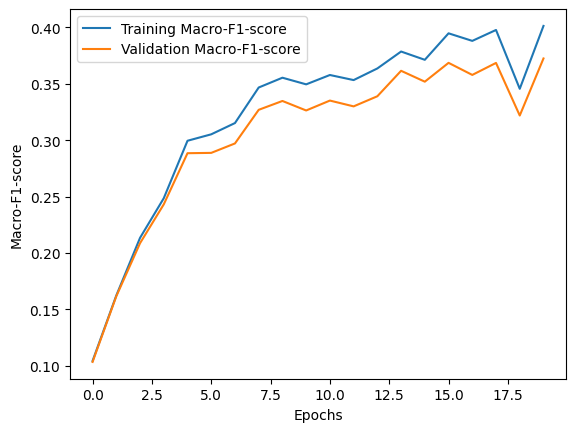

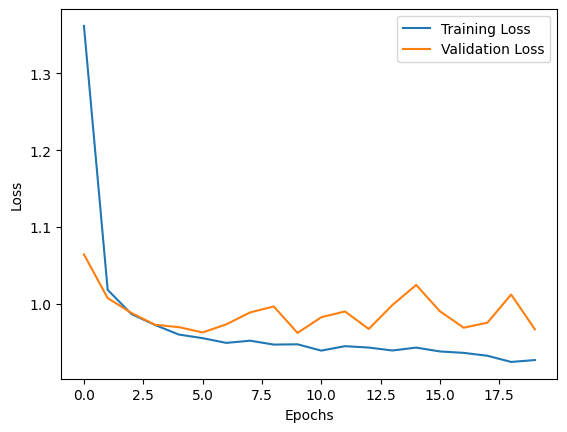

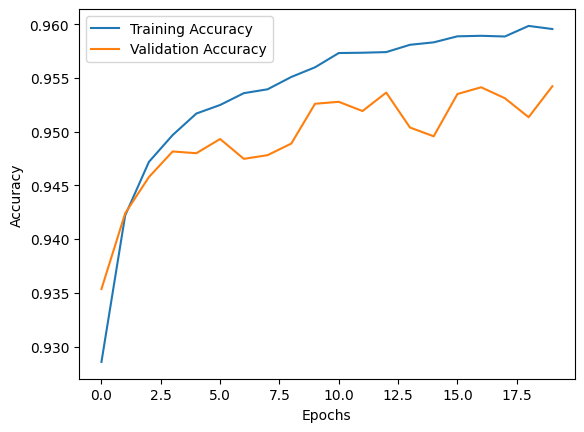

In [12]:
# Define the RNN model architecture
model = tf.keras.Sequential([
    tf.keras.layers.GRU(units=128, return_sequences=True, input_shape=(70, 100)),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.Dense(27, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Train the model and Initialize lists to store F1-score values
train_f1_scores = []
val_f1_scores = []
train_losses = []
val_losses = []
train_acc = []
val_acc = []

train_f1_scores_per_label = []
val_f1_scores_per_label = []

for epoch in range(20):
    # Perform one epoch of training
    history = model.fit(X_train, y_train, epochs=1, batch_size=32, verbose=True, validation_data=(X_val, y_val), callbacks=[early_stopping])

    # Get predictions for training and validation data
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # Convert one-hot encoded labels back to integer labels
    y_train_true = np.argmax(y_train, axis=-1)
    y_val_true = np.argmax(y_val, axis=-1)

    # Calculate F1-score for training and validation data
    train_f1 = f1_score(y_train_true.flatten(), y_train_pred.argmax(axis=2).flatten(), average='macro')
    val_f1 = f1_score(y_val_true.flatten(), y_val_pred.argmax(axis=2).flatten(), average='macro')

    train_f1_per_label = f1_score(y_train_true.flatten(), y_train_pred.argmax(axis=2).flatten(), average=None)
    val_f1_per_label = f1_score(y_val_true.flatten(), y_val_pred.argmax(axis=2).flatten(), average=None)
    
    # Append F1-score values to lists
    train_f1_scores_per_label.append(train_f1_per_label)
    val_f1_scores_per_label.append(val_f1_per_label)
    
    # Append F1-score values to lists
    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)

    # Append losses to lists
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])

    # Append accuracy to lists
    train_acc.append(history.history['accuracy'])
    val_acc.append(history.history['val_accuracy'])

    # Print F1-score and accuracy for each epoch
    print(f'Epoch {epoch + 1}: Training Macro-F1-score: {train_f1}, Validation Macro-F1-score: {val_f1}')
    print(f'Epoch {epoch + 1}: Training Accuracy: {history.history["accuracy"][-1]}, Validation Accuracy: {history.history["val_accuracy"][-1]}')

# Plot F1-score
plt.plot(train_f1_scores, label='Training Macro-F1-score')
plt.plot(val_f1_scores, label='Validation Macro-F1-score')
plt.xlabel('Epochs')
plt.ylabel('Macro-F1-score')
plt.legend()
plt.savefig('/task_1_Fasttext_simple_RNN_f1_score.png')  # Save F1-score figure
plt.show()

# Plot Loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/task_1_Fasttext_simple_RNN_loss.png')  # Save loss figure
plt.show()

# Plot Accuracy
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('/task_1_Fasttext_simple_RNN_accuracy.png')  # Save accuracy figure
plt.show()


In [13]:
model.save('/task_1_Fasttext_GRU_Dataset_1.keras')

## Test data

In [14]:
# test data
def load_data(file):
    with open(file, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data

data_test = load_data("/Dataset1-NamedEntityRecognition_test.json")

texts_test = [data_test[key]["text"] for key in data_test]
words_test = [sentence.split() for sentence in texts_test]
nested_labels_test = [data_test[key]["labels"] for key in data_test]

In [15]:
fasttext_model_test = FastText(texts_test, vector_size=100, min_count=1, epochs=10)

# Create word vectors dictionary with consistent lowercase keys
word_vectors_test = {}
for word in fasttext_model_test.wv.index_to_key:
    try:
        word_vectors_test[word.lower()] = fasttext_model_test.wv[word.lower()]
    except KeyError:
        # Handle out-of-vocabulary words
        pass

# Handle out-of-vocabulary (OOV) words in get_word_vector function
def get_word_vector(word):
    word_lower = word.lower()  # Ensure lowercase for consistency
    if word_lower in word_vectors_test:
        return word_vectors_test[word_lower]
    else:
        # Choose an appropriate strategy for OOV words:
        # - Return the zero vector (default)
        # - Use word averaging or other embedding techniques
        # - Handle OOV cases differently depending on your specific requirements
        return np.zeros(fasttext_model_test.vector_size)
    
word_embeddings_test = [[get_word_vector(word)  for word in sentence] for sentence in words_test]
max_wordem = max([len(sentence) for sentence in word_embeddings_test])


In [16]:
for sentence in word_embeddings_test:
    sentence_length = len(sentence)
    if sentence_length < 70:
        while len(sentence) < 70: #max_wordem
            sentence.append(np.zeros(100))  
            
# padding to convert into (949, 70, 100)  from (949, variable_length, 70)           
for i in range(len(word_embeddings_test)):
    word_embeddings_test[i] = np.array(word_embeddings_test[i])
word_embeddings_test = np.array(word_embeddings_test)
word_embeddings_test.shape      

(949, 70, 100)

In [17]:
# flat_labels_test = [label for sublist in nested_labels_test for label in sublist]

# # Find unique labels
# unique_labels_test = set(flat_labels_test)

# print(unique_labels_test)

# label2idx_test = {label: idx for idx, label in enumerate(unique_labels_test)}
labels_idx_test = [[label2idx[label] for label in sublist] for sublist in nested_labels_test]

# One-hot encode labels
# num_classes_test = len(unique_labels_test)
one_hot_labels_test = [to_categorical(sublist, num_classes=27) for sublist in labels_idx_test]

In [18]:
def convert_to_list(lst):
    if isinstance(lst, np.ndarray):
        return lst.tolist()
    elif isinstance(lst, list):
        return [convert_to_list(item) for item in lst]
    else:
        return lst
labels_padded_test = convert_to_list(one_hot_labels_test)

In [19]:
for sentence in labels_padded_test:
    sentence_length = len(sentence)
    if sentence_length < 70: #max length of sentence = 70
        while len(sentence) < 70:
            sentence.append([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

labels_padded_test = np.array(labels_padded_test)
labels_padded_test.shape

(949, 70, 27)

In [20]:
X_test_padded = word_embeddings_test
y_test_padded = labels_padded_test

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test_padded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

30/30 [==============================] - 0s 10ms/step - loss: 5.3032 - accuracy: 0.8921
Test Loss: 5.303248405456543
Test Accuracy: 0.8920969367027283


In [ ]:
y_pred = model.predict(X_test_padded)
# Assuming y_pred contains continuous values, convert them to class labels
y_pred_classes = np.argmax(y_pred, axis=2).flatten()
y_test_classes = np.argmax(y_test_padded, axis=2).flatten()
target_names = [str(label) for label in unique_labels]
# target_names = [str(label) for label in range(27)]  # Assuming you have 27 unique labels
# Generate the classification report using true target values and predicted target values
report = classification_report(y_test_classes, y_pred_classes, target_names=target_names)
print(report)
